# Analyzing Internet of Things Data with IBM DSX: Trucking Data Analysis.

In this notebook you will see how to build a predictive model with Spark machine learning API (SparkML) and deploy it for scoring in Machine Learning (ML) in IBM DSX platform.
This notebook walks you through following steps:
- Fetching data from HDFS
- Feature engineering
- Data Visualization
- Build a binary classifier model with SparkML API
- Save the model in the ML repository
- Deploy model online(via UI)
- Test the model (via UI)
- Test the model (via REST API).

# Use Case

Imagine a trucking company that dispatches trucks across the country. The trucks are outfitted with sensors that collect data – data like location of the driver, weather conditions, and even what event recently occured (speeding, the truck weaving out of its lane, following too closely, etc). Data like this is generated very often, say once per second and is streamed back to the company’s servers.

The company needs a way to process this stream of data and run some analysis on the data so that it can make sure trucks are traveling safe and if the driver is likely to make any violations anytime soon. Oh, and this also needs to be done in real-time!


![CRISP-DM](https://raw.githubusercontent.com/dhananjaymehta/IoTtrucking/master/trucks2.jpg)





For predicting violations, we are simulating trucking events in terms of location, miles driven, weather conditions. Next step is to visually understand the data and correlations between different features. We will also need to do some feature engineering for data preparation. 

Once the data is ready, we can build a predictive model. In our example we are using the SparkML Random Forrest classification model. Classification is a statistical technique which assigns a "class" to each driver - **"Violations"** or **"Normal"**. We build the classification models using historical data to train our model. (In a typical analytics project large training datasets will be used but we are building this demo model with a small datasets)

If a model's meets accuracy expectations, it is good to be deployed for scoring. 

Scoring is the process of applying the model to a new set of data.

In [5]:
import numpy as np
import pandas as pd
from pyspark import SparkContext
from pyspark.sql import SQLContext, SparkSession
#sc=SparkContext()

## Step 1: Import HDFS Data from remote HDP cluster.

In [6]:
# view dataset
!wget -i -L "https://raw.githubusercontent.com/roberthryniewicz/datasets/master/IoT-Trucking-Demo.csv" | tail -n 5

--2018-04-18 21:05:27--  https://raw.githubusercontent.com/roberthryniewicz/datasets/master/IoT-Trucking-Demo.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.60.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.60.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28555 (28K) [text/plain]
Saving to: ‘IoT-Trucking-Demo.csv.2’

IoT-Trucking-Demo.c 100%[=====================>]  27.89K  --.-KB/s   in 0.009s 

2018-04-18 21:05:28 (3.02 MB/s) - ‘IoT-Trucking-Demo.csv.2’ saved [28555/28555]

-L: No such file or directory
No URLs found in -L.
FINISHED --2018-04-18 21:05:28--
Total wall clock time: 0.2s
Downloaded: 1 files, 28K in 0.009s (3.02 MB/s)


#### Load Events Data

In [7]:
!pwd

/user-home/1023/DSX_Projects/Data_Science_user0xx/jupyter


In [8]:
!ls

IoT-Trucking-Demo.csv	 IoT_Trucking_Demo_Hortonoworks-CC-Berlin.jupyter.ipynb
IoT-Trucking-Demo.csv.1  target
IoT-Trucking-Demo.csv.2


In [9]:
# Training Data : from HDFS
#DSX_PROJECT_DIR='/user-home/1002/DSX_Projects/Final DSX Test - Shared/datasets/'
eventsFile = SQLContext(sc).read.csv('./IoT-Trucking-Demo.csv', header='true', inferSchema = 'false')  # this will load it as Spark DataFrame
# see the data
eventsFile.show(5)
# total number of records
tot_row = eventsFile.count()

# events with violations
tot_violations = eventsFile.filter("iscertified == 'N'").count()
tot_no_violations = tot_row - tot_violations
print(type(eventsFile), tot_row)
print("Violations: " + str(tot_violations) + "; No violations: " + str(tot_no_violations))

+--------------+-----------+-------------+-----------+-----------+--------+---------+-------+-------+-------+
|      eventtyp|iscertified|paymentscheme|hoursdriven|milesdriven|latitude|longitude|isfoggy|israiny|iswindy|
+--------------+-----------+-------------+-----------+-----------+--------+---------+-------+-------+-------+
|        Normal|          N|        miles|         70|       3300|  -95.01|    36.73|      0|      1|      1|
|Lane Departure|          N|        miles|         70|       3300|  -91.99|    37.94|      0|      0|      0|
|Lane Departure|          N|        miles|         70|       3300|  -92.08|    37.81|      0|      1|      1|
|Lane Departure|          N|        miles|         70|       3300|   -95.5|    36.37|      1|      1|      1|
|Lane Departure|          N|        miles|         70|       3300|  -94.23|    37.09|      1|      1|      1|
+--------------+-----------+-------------+-----------+-----------+--------+---------+-------+-------+-------+
only showi

In [10]:
eventsFile.show(5)

+--------------+-----------+-------------+-----------+-----------+--------+---------+-------+-------+-------+
|      eventtyp|iscertified|paymentscheme|hoursdriven|milesdriven|latitude|longitude|isfoggy|israiny|iswindy|
+--------------+-----------+-------------+-----------+-----------+--------+---------+-------+-------+-------+
|        Normal|          N|        miles|         70|       3300|  -95.01|    36.73|      0|      1|      1|
|Lane Departure|          N|        miles|         70|       3300|  -91.99|    37.94|      0|      0|      0|
|Lane Departure|          N|        miles|         70|       3300|  -92.08|    37.81|      0|      1|      1|
|Lane Departure|          N|        miles|         70|       3300|   -95.5|    36.37|      1|      1|      1|
|Lane Departure|          N|        miles|         70|       3300|  -94.23|    37.09|      1|      1|      1|
+--------------+-----------+-------------+-----------+-----------+--------+---------+-------+-------+-------+
only showi

## Step 2: Data Wrangling

In [13]:
# old column names
old_col_names = eventsFile.columns
# new names to be assigned
new_col_names =['eventtyp', 'iscertified', 'paymentscheme', 'hoursdriven', 'milesdriven', 'latitude', 'longitude', 'isfoggy', 'israiny', 'iswindy']

# Renaming the columns
eventsdata = reduce(lambda eventsFile, idx: eventsFile.withColumnRenamed(old_col_names[idx], new_col_names[idx]), range(len(old_col_names)), eventsFile)
eventsdata.printSchema()

root
 |-- eventtyp: string (nullable = true)
 |-- iscertified: string (nullable = true)
 |-- paymentscheme: string (nullable = true)
 |-- hoursdriven: string (nullable = true)
 |-- milesdriven: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- isfoggy: string (nullable = true)
 |-- israiny: string (nullable = true)
 |-- iswindy: string (nullable = true)



### Type conversion for Columns

In [14]:
data=eventsdata.withColumn("latitude", eventsdata["latitude"].cast("float")).withColumn("longitude", eventsdata["longitude"].cast("float")).withColumn("hoursdriven", eventsdata["hoursdriven"].cast("int")).withColumn("isfoggy", eventsdata["isfoggy"].cast("int")).withColumn("israiny", eventsdata["israiny"].cast("int")).withColumn("iswindy", eventsdata["iswindy"].cast("int")).withColumn("milesdriven", eventsdata["milesdriven"].cast("int"))

# view final schema
data.printSchema()

root
 |-- eventtyp: string (nullable = true)
 |-- iscertified: string (nullable = true)
 |-- paymentscheme: string (nullable = true)
 |-- hoursdriven: integer (nullable = true)
 |-- milesdriven: integer (nullable = true)
 |-- latitude: float (nullable = true)
 |-- longitude: float (nullable = true)
 |-- isfoggy: integer (nullable = true)
 |-- israiny: integer (nullable = true)
 |-- iswindy: integer (nullable = true)



### Feature Engineering

** Transforming truck events** eventType

eventType into binary (Y/N) ifViolated

**N** - if driving is 'Normal' and there are no violations

**Y** - ['Lane Departure', 'Overspeed','Unsafe following distance', 'Unsafe tail distance']

In [15]:
# creating a pandas dataframe 
data_pandas=data.toPandas()
type(data_pandas)

pandas.core.frame.DataFrame

In [16]:
# unique trucking events
truck_events= list(data_pandas['eventtyp'].unique())
truck_events

[u'Normal',
 u'Lane Departure',
 u'Overspeed',
 u'Unsafe following distance',
 u'Unsafe tail distance']

In [17]:
# transform column eventType
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import StringType

name = 'eventtyp'
udf = UserDefinedFunction(lambda x: 'N' if x=="Normal" else 'Y', StringType())
data_tran=data.select(*[udf(column).alias(name) if column == name else column for column in data.columns])

In [18]:
data_pandas=data_tran.toPandas()  # use updated dataframe

#### Register table for Enriched Events

In [19]:
data.registerTempTable("enrichedEvents")

## Step 3: Exploratory analysis

In [20]:
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
%matplotlib inline

# set plot size
fig_size=[0,0]
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

# setting temp dataframe =
df = data_pandas

# setting style
sns.set_style("whitegrid")
warnings.filterwarnings('ignore')

#### Feature transformation in pandas

**Note:** This is for visualization purpose only

Setting int values for column

- eventTyp:
    - 1 if Violation 
    - 0 for Normal

- isCertified: 
    - 1 if Certified 
    - 0 for Not Certified

- paymentScheme: 
    - 1 if "hours" 
    - 0 for "miles"

In [21]:
df["eventtyp"].unique()

array([u'N', u'Y'], dtype=object)

In [22]:
df['eventtyp'] = df['eventtyp'].apply(lambda x: 0 if x=='N' else 1)

In [23]:
df['iscertified'] = df['iscertified'].apply(lambda x: 0 if x=='N' else 1)
df['paymentscheme'] = df['paymentscheme'].apply(lambda x: 0 if x=='miles' else 1)

In [24]:
df.head(5)

,eventtyp,iscertified,paymentscheme,hoursdriven,milesdriven,latitude,longitude,isfoggy,israiny,iswindy
0,0,0,0,70,3300,-95.010002,36.730000,0,1,1
1,1,0,0,70,3300,-91.989998,37.939999,0,0,0
2,1,0,0,70,3300,-92.080002,37.810001,0,1,1
3,1,0,0,70,3300,-95.500000,36.369999,1,1,1
4,1,0,0,70,3300,-94.230003,37.090000,1,1,1


**listing the columns**

['eventTyp',
 'isCertified',
 'paymentScheme',
 'hoursDriven',
 'milesDriven',
 'latitude',
 'longitude',
 'isFoggy',
 'isRainy',
 'isWindy']

### Correlation Matrix for features

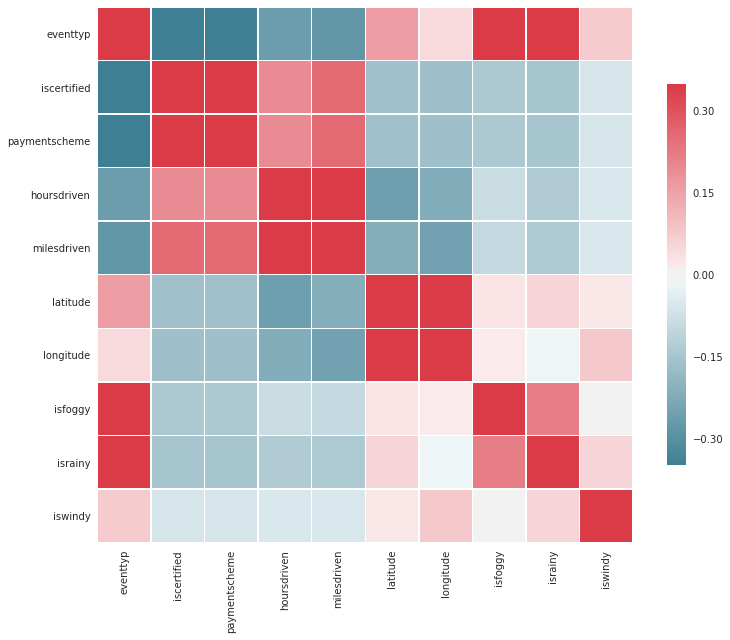

In [25]:
# Compute the correlation matrix
corr = df.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .7})

e.g. more miles driven => more seasoned drivers => negative correlation with violations taking place (i.e. eventtyp = 0)

### Visualizing multidimensional relationships

*exploring correlations between multidimensional data, when you'd like to plot all pairs of values against each other.*

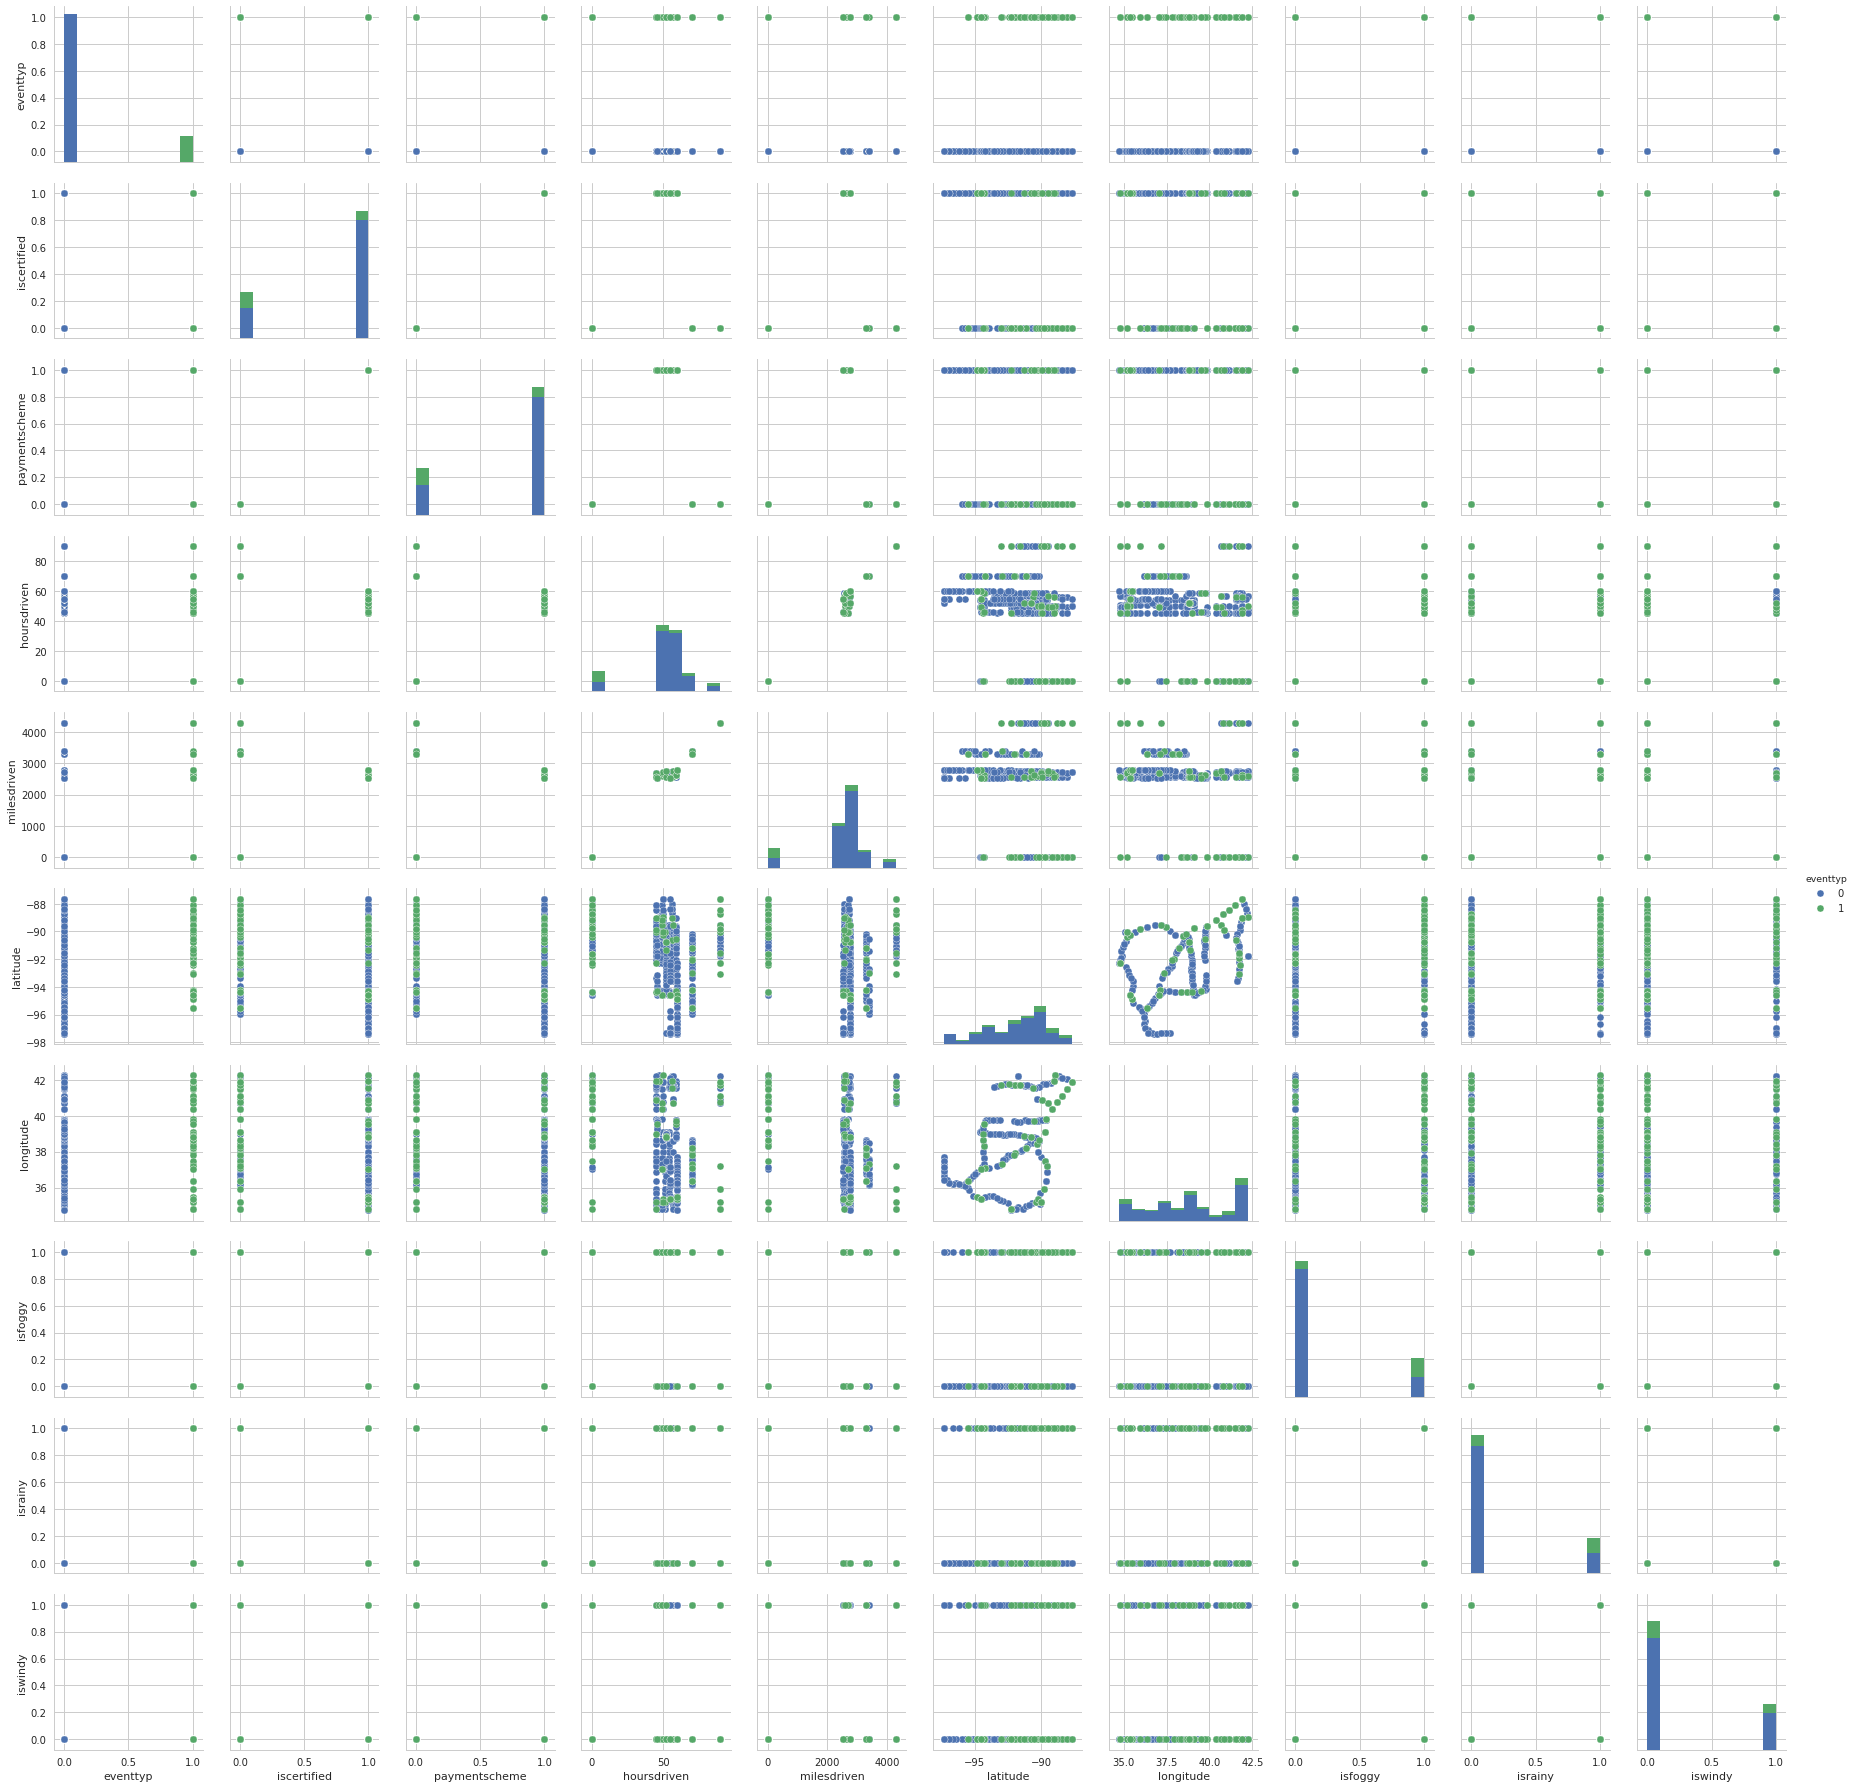

In [26]:
sns.pairplot(df, hue='eventtyp', size=2.5);
plt.show()    

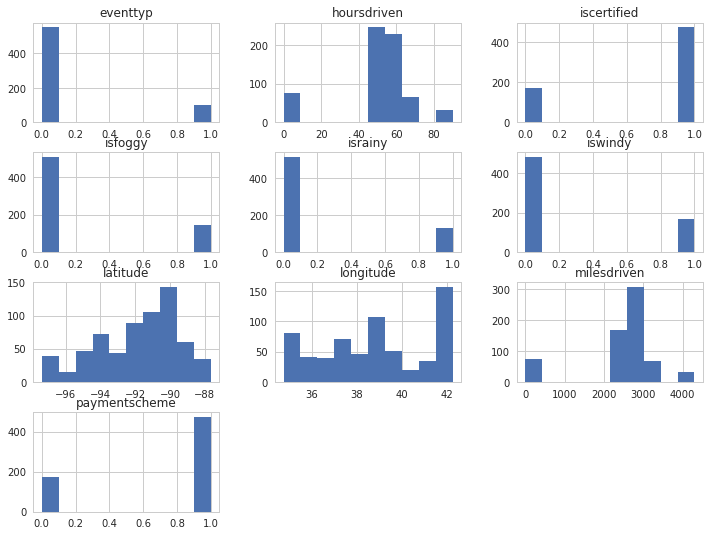

In [27]:
df.hist()
plt.show()

### Do certified drivers have less violations?

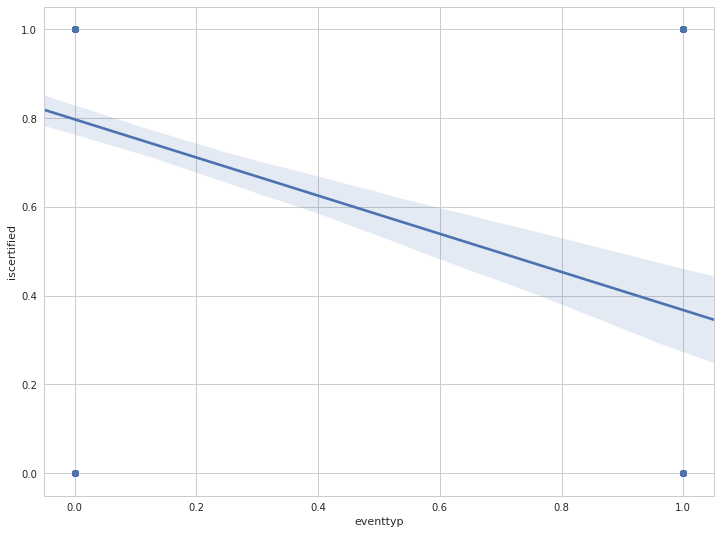

In [28]:
# Bar Plot
sns.regplot(x="eventtyp", y="iscertified", data=df)
plt.show()

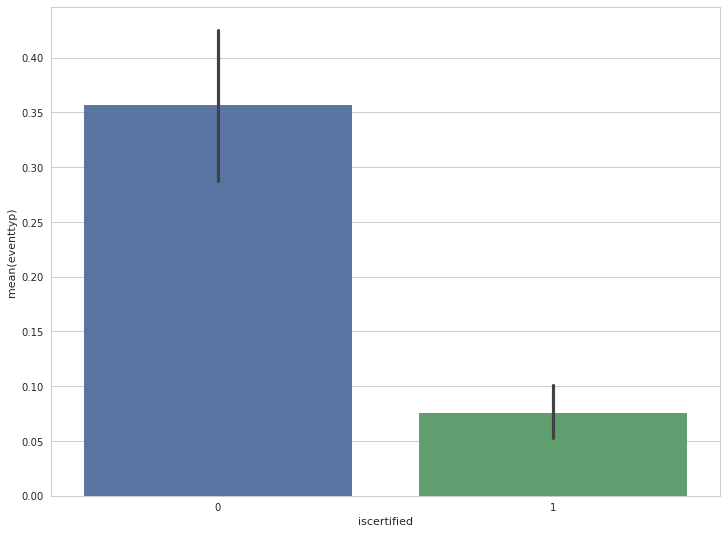

In [29]:
sns.barplot(y="eventtyp", x="iscertified", data=df)
plt.show()

### Correleation btw hours driven and violations?

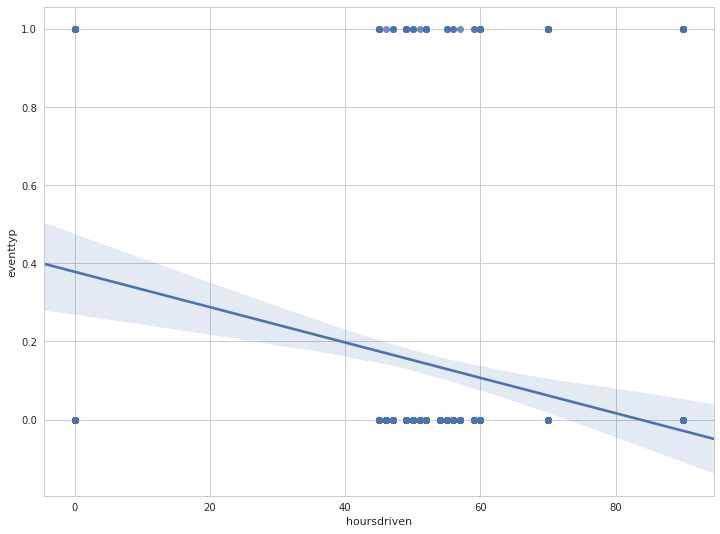

In [30]:
ax = sns.regplot(x="hoursdriven", y="eventtyp", data=df)

### What are median hours driven by a driver?

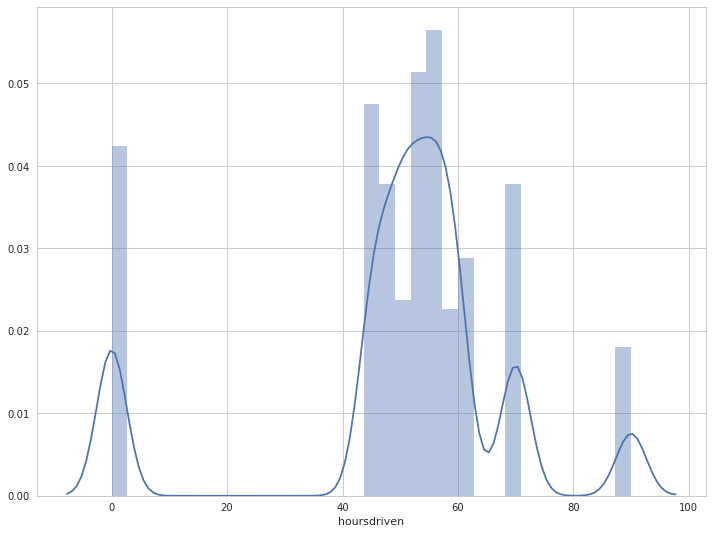

In [31]:
sns.distplot(df["hoursdriven"]);

### What are median miles driven by a driver?

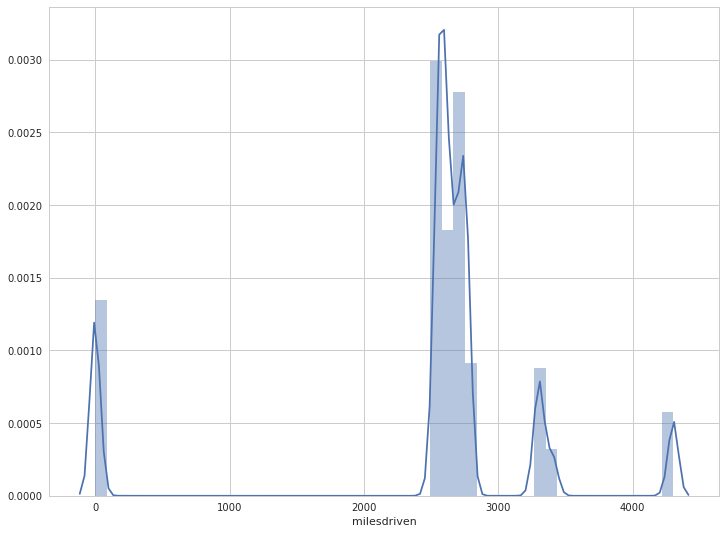

In [32]:
sns.distplot(df["milesdriven"]);

## Step 4: Building a classifier to predict truck event

In [33]:
# verify data schema
data_tran.printSchema()

root
 |-- eventtyp: string (nullable = true)
 |-- iscertified: string (nullable = true)
 |-- paymentscheme: string (nullable = true)
 |-- hoursdriven: integer (nullable = true)
 |-- milesdriven: integer (nullable = true)
 |-- latitude: float (nullable = true)
 |-- longitude: float (nullable = true)
 |-- isfoggy: integer (nullable = true)
 |-- israiny: integer (nullable = true)
 |-- iswindy: integer (nullable = true)



In [34]:
data_tran.show(5)

+--------+-----------+-------------+-----------+-----------+--------+---------+-------+-------+-------+
|eventtyp|iscertified|paymentscheme|hoursdriven|milesdriven|latitude|longitude|isfoggy|israiny|iswindy|
+--------+-----------+-------------+-----------+-----------+--------+---------+-------+-------+-------+
|       N|          N|        miles|         70|       3300|  -95.01|    36.73|      0|      1|      1|
|       Y|          N|        miles|         70|       3300|  -91.99|    37.94|      0|      0|      0|
|       Y|          N|        miles|         70|       3300|  -92.08|    37.81|      0|      1|      1|
|       Y|          N|        miles|         70|       3300|   -95.5|    36.37|      1|      1|      1|
|       Y|          N|        miles|         70|       3300|  -94.23|    37.09|      1|      1|      1|
+--------+-----------+-------------+-----------+-----------+--------+---------+-------+-------+-------+
only showing top 5 rows



### Algorithm Used: RandomForest Classifier

Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks, that operate by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. Random decision forests correct for decision trees' habit of overfitting to their training set.

In [35]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorIndexer, IndexToString
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier

We are using **ML Pipelines** provide a uniform set of high-level APIs built on top of DataFrames that help users create and tune practical machine learning pipeline

A **Pipeline** is specified as a sequence of stages, and each stage is either a **Transformer** or an **Estimator**. These stages are run in order, and the input DataFrame is transformed as it passes through each stage. 

For Estimator stages, the fit() method is called to produce a Transformer (which becomes part of the PipelineModel, or fitted Pipeline), and that Transformer’s transform() method is called on the DataFrame.

![CRISP-DM](https://raw.githubusercontent.com/dhananjaymehta/IoTtrucking/master/fit.png)

For Transformer stages, the transform() method is called on the DataFrame. 

![CRISP-DM](https://raw.githubusercontent.com/dhananjaymehta/IoTtrucking/master/transform.png)



For more details ref: https://spark.apache.org/docs/2.1.1/ml-pipeline.html

In [36]:
# Prepare string variables so that they can be used by the decision tree algorithm
# StringIndexer encodes a string column of labels to a column of label indices

SI1 = StringIndexer(inputCol='iscertified',outputCol='iscertifiedEncoded')
SI2 = StringIndexer(inputCol='paymentscheme',outputCol='paymentschemeEncoded')

#encode the Label column
labelIndexer = StringIndexer(inputCol='eventtyp', outputCol='label').fit(data_tran)

# Pipelines API requires that input variables are passed in  a vector
assembler = VectorAssembler(inputCols=["iscertifiedEncoded", "paymentschemeEncoded", "hoursdriven", "milesdriven", "latitude", \
                                       "longitude", "isfoggy", "israiny", "iswindy"], outputCol="features")

In [37]:
# instantiate the algorithm, take the default settings
rf=RandomForestClassifier(labelCol="label", featuresCol="features")

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=labelIndexer.labels)

pipeline = Pipeline(stages=[SI1,SI2,labelIndexer, assembler, rf, labelConverter])

In [38]:
# Split data into train and test datasets
train, test = data_tran.randomSplit([0.8,0.2], seed=6)
train.cache()

DataFrame[eventtyp: string, iscertified: string, paymentscheme: string, hoursdriven: int, milesdriven: int, latitude: float, longitude: float, isfoggy: int, israiny: int, iswindy: int]

In [39]:
test.cache()

DataFrame[eventtyp: string, iscertified: string, paymentscheme: string, hoursdriven: int, milesdriven: int, latitude: float, longitude: float, isfoggy: int, israiny: int, iswindy: int]

In [40]:
train.printSchema()

root
 |-- eventtyp: string (nullable = true)
 |-- iscertified: string (nullable = true)
 |-- paymentscheme: string (nullable = true)
 |-- hoursdriven: integer (nullable = true)
 |-- milesdriven: integer (nullable = true)
 |-- latitude: float (nullable = true)
 |-- longitude: float (nullable = true)
 |-- isfoggy: integer (nullable = true)
 |-- israiny: integer (nullable = true)
 |-- iswindy: integer (nullable = true)



In [41]:
train.show(5)

+--------+-----------+-------------+-----------+-----------+--------+---------+-------+-------+-------+
|eventtyp|iscertified|paymentscheme|hoursdriven|milesdriven|latitude|longitude|isfoggy|israiny|iswindy|
+--------+-----------+-------------+-----------+-----------+--------+---------+-------+-------+-------+
|       N|          N|        miles|          0|          0|  -94.59|     39.1|      0|      0|      0|
|       N|          N|        miles|          0|          0|  -94.58|    37.03|      0|      0|      0|
|       N|          N|        miles|          0|          0|  -94.46|    37.16|      1|      1|      1|
|       N|          N|        miles|          0|          0|  -94.38|    38.99|      0|      0|      1|
|       N|          N|        miles|          0|          0|  -91.94|    41.71|      0|      0|      0|
+--------+-----------+-------------+-----------+-----------+--------+---------+-------+-------+-------+
only showing top 5 rows



In [42]:
# Build model. 
# The fitted model from a Pipeline is a PipelineModel, which consists of fitted models and transformers, corresponding to the pipeline stages.
model = pipeline.fit(train)

### Score test dataset

In [43]:
results = model.transform(test)

In [44]:
results.show(5)

+--------+-----------+-------------+-----------+-----------+--------+---------+-------+-------+-------+------------------+--------------------+-----+--------------------+--------------------+--------------------+----------+--------------+
|eventtyp|iscertified|paymentscheme|hoursdriven|milesdriven|latitude|longitude|isfoggy|israiny|iswindy|iscertifiedEncoded|paymentschemeEncoded|label|            features|       rawPrediction|         probability|prediction|predictedLabel|
+--------+-----------+-------------+-----------+-----------+--------+---------+-------+-------+-------+------------------+--------------------+-----+--------------------+--------------------+--------------------+----------+--------------+
|       N|          N|        miles|          0|          0|  -94.35|    38.33|      0|      0|      0|               1.0|                 1.0|  0.0|(9,[0,1,4,5],[1.0...|[14.7938558994312...|[0.73969279497156...|       0.0|             N|
|       N|          N|        miles|        

### Showing the prediction results of binary classifier: 

In [45]:
results=results.select(results["eventtyp"],results["label"],results["predictedlabel"],results["prediction"],results["probability"])
results.toPandas().head(5)

,eventtyp,label,predictedlabel,prediction,probability
0,N,0.0,N,0.0,"[0.7396927949715618, 0.2603072050284382]"
1,N,0.0,N,0.0,"[0.8110377841731278, 0.18896221582687223]"
2,N,0.0,Y,1.0,"[0.10311688311688313, 0.896883116883117]"
3,N,0.0,N,0.0,"[0.8051521420374856, 0.1948478579625143]"
4,N,0.0,N,0.0,"[0.861275879411223, 0.13872412058877698]"


### Model evaluation

In [46]:
print ('Model accuracy = {:.2f}'.format(results.filter(results.label == results.prediction).count() / float(results.count())))

Model accuracy = 0.88


In [47]:
TP = (results.filter(results.label == results.prediction).filter(results.prediction == 1.0)).count() # True positive => predicted violation and it did occur
TP

13

In [48]:
FP = (results.filter(results.label != results.prediction).filter(results.prediction == 1.0)).count() # False positive => predicted violation that did not occur
FP

2

In [49]:
precision = float(TP) / (TP + FP)
print "Model precision = {:.2f}".format(precision)

Model precision = 0.87


In [50]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="label", metricName="areaUnderROC")
print 'Area under ROC curve = {:.2f}'.format(evaluator.evaluate(results))

Area under ROC curve = 0.74


### Area Under ROC Curve

The area under the ROC curve (AUC) is a measure of how well a parameter can distinguish between two groups: violation vs no violation.
In a ROC curve the true positive rate (Sensitivity) is plotted in function of the false positive rate (Specifity). See https://www.medcalc.org/manual/roc-curves.php

#### Evaluation Criteria

- .90-1 = excellent (A)
- .80-.90 = good (B)
- .70-.80 = fair (C)
- .60-.70 = poor (D)
- .50-.60 = fail (F)




## Step 5: Save Model in ML repositor

service_path = 'https://internal-nginx-svc.ibm-private-cloud.svc.cluster.local:12443'


In [47]:
type(model)

pyspark.ml.pipeline.PipelineModel

### Create the model artifact (abstraction layer)

In [52]:
from dsx_ml.ml import save
model_name="Product Line Predicton Model"
save(model=model, name=name, test_data=test, algorithm_type="Classification")

Using TensorFlow backend.


{'path': '/user-home/1023/DSX_Projects/Data_Science_user0xx/models/eventtyp/1',
 'scoring_endpoint': 'https://dsxl-api.ibm-private-cloud.svc.cluster.local/v3/project/score/Python27/spark-2.0/Data_Science_user0xx/eventtyp/1'}

In [ ]:
import requests
import os

online_path ='http://dsxl-api.ibm-private-cloud.svc.cluster.local/v3/score/unpublished/{0}/{1}'.format(
os.environ['DSX_PROJECT_NAME'],
model_name
)

header_online = {'Content-Type': 'application/json', 'Authorization': os.environ['DSX_TOKEN']}

payload_scoring = [{"feature": "value"}]

requests.post(online_path, json=payload_scoring, headers=header_online)

### Save pipeline and model artifacts to in Machine Learning repository

### Saved model properties

##  Step 6: Deploy and Test model

### Test with UI

Save the notebook and click **model** tab under your Project Assets tab of the project (hint: open with another tab in your browser).
Click your model and then click on add deployment. Add an Online deployment and use the the Test API option to test the model.

**You can use the following data for testing:**
- **X**
isCertified=N | paymentScheme=miles | hoursDriven=70 | milesDriven=3300 | latitude=-95.01 | longitude36.73 | isFoggy=0 | isRainy=1 | isWindy=1

- **Y**
eventTyp - Y(1) and N(0)

<img style="float: left;" src="https://github.com/dhananjaymehta/IoTtrucking/blob/master/UI_Test.png?raw=true" alt="Test API" width=800 />

## Step 7: Monitor model performance

You can manage your models using Model Management tools. Click on **Model Management** on top left corner of you IBM DSX Local Experience. It will give a dashboard listing all the Models and deployments.

<img style="float: left;" src="https://github.com/dhananjaymehta/IoTtrucking/blob/master/dashboard.png?raw=true" alt="Model Management" width=800 />